# playing around with a network
https://grand.networkmedicine.org/cell/Lung_Cancer/
cellline HCC827

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import variation
from networkx.algorithms import approximation as approx
import powerlaw

ModuleNotFoundError: No module named 'powerlaw'

In [ ]:
def create_directed_graph(adj):
    """
    Create a directed graph from an adjacency matrix.
    """
    edges = adj.stack().reset_index()
    edges.columns = ['source', 'target', 'weight']
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges.values)
    del adj
    return G


In [ ]:
def get_experiment_score(gene_list):
    return target_counts.loc[target_counts.index.intersection(gene_list), 'count'].sum()


def get_experiment_statistics(node_list, n_edges):
    score_dict = {
        "genes": len(node_list),
        "edges": n_edges,
        "target_genes": {
            "landmark": 0,
            "best_inferred": 0,
            "inferred": 0
        },
        "experiments": {
            "landmark": 0,
            "best_inferred": 0,
            "inferred": 0
        }
    }

    for feature in ["landmark", "best inferred", "inferred"]:
        relevant_genes = set(node_list) & set(target_counts[target_counts['feature_space'] == feature].index)
        key = feature.replace(" ", "_")
        score_dict["target_genes"][key] = len(relevant_genes)
        score_dict["experiments"][key] = get_experiment_score(relevant_genes)

    return score_dict

def get_structure_statistics(G):
    degrees = [d for n, d in G.degree()]
    stats = {}

    if len(degrees) == 0:
        return {
            "avg_degree": 0,
            "clustering": 0,
            "avg_path_length": None,
            "degree_var": 0,
            "gini": 0,
            "powerlaw_alpha": None,
        }

    stats["avg_degree"] = np.mean(degrees)
    stats["degree_var"] = np.var(degrees)
    stats["gini"] = gini_coefficient(degrees)
    stats["clustering"] = nx.average_clustering(G)

    if nx.is_connected(G):
        stats["avg_path_length"] = nx.average_shortest_path_length(G)
    else:
        stats["avg_path_length"] = approx.average_shortest_path_length(G)

    if len(degrees) >= 50:
        fit = powerlaw.Fit(degrees, verbose=False)
        stats["powerlaw_alpha"] = round(fit.power_law.alpha, 2)
    else:
        stats["powerlaw_alpha"] = None

    return stats


def gini_coefficient(array):
    array = np.array(array)
    if np.amin(array) < 0:
        array -= np.amin(array)  # shift to non-negative
    array = np.sort(array)
    n = len(array)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

In [ ]:
def print_statistics(score_dict):
    print("==========================")
    print(f"Total number of nodes: {score_dict['genes']}")
    print(f"Total number of edges: {score_dict['edges']}")
    print("-----------------------------")
    print(f"Target genes (landmark): {score_dict['target_genes']['landmark']}")
    print(f"Target genes (best_inferred): {score_dict['target_genes']['best_inferred']}")
    print(f"Target genes (inferred): {score_dict['target_genes']['inferred']}")
    print("-----------------------------")
    print(f"Experiment score (landmark): {score_dict['experiments']['landmark']}")
    print(f"Experiment score (best_inferred): {score_dict['experiments']['best_inferred']}")
    print(f"Experiment score (inferred): {score_dict['experiments']['inferred']}")
    print("-----------------------------")
    print(f"Avg degree: {round(score_dict['avg_degree'], 2)}")
    print(f"Degree variance: {round(score_dict['degree_var'], 2)}")
    print(f"Gini coefficient: {round(score_dict['gini'], 3)}")
    print(f"Avg clustering coefficient: {round(score_dict['clustering'], 3)}")
    print(f"Avg path length: {score_dict['avg_path_length']}")
    print(f"Power-law alpha (scale-free): {score_dict['powerlaw_alpha']}")

In [ ]:
def filter_edges_by_threshold(G: nx.DiGraph, threshold, keep_connected=True):
    # Remove edges with weight less than the threshold
    edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w['weight'] < threshold]
    G.remove_edges_from(edges_to_remove)
    
    if keep_connected:
        # Remove nodes that are not strongly connected
        # Get the largest strongly connected component
        largest_cc = max(nx.weakly_connected_components(G), key=len)
        # Remove nodes not in the largest strongly connected component
        nodes_to_remove = set(G.nodes) - largest_cc
    else:
        # Remove nodes with no incoming or outgoing edges
        nodes_to_remove = [n for n in G.nodes if G.in_degree(n) == 0 and G.out_degree(n) == 0]

    G.remove_nodes_from(nodes_to_remove)
    
    return G
    



In [ ]:
def collect_statistics(thresholds, G):
    statistics_list = []

    for threshold in thresholds:
        print(f"\n=== Threshold: {threshold} ===")
        G_filtered = filter_edges_by_threshold(G, threshold, keep_connected=False)
        node_list = list(G_filtered.nodes())
        experiment_statistics = get_experiment_statistics(node_list, G_filtered.number_of_edges())

        # Add network structure statistics
        structure_stats = get_structure_statistics(G_filtered)
        experiment_statistics.update(structure_stats)

        statistics_list.append(experiment_statistics)
        print_statistics(experiment_statistics)

    return statistics_list

In [ ]:
import matplotlib.pyplot as plt

def plot_statistics_list(statistics_list, thresholds):
    # Create a grid of 3x2 subplots
    fig, axs = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Graph & Experiment Statistics by Threshold', fontsize=22)

    # --- Plot 1: Number of Nodes ---
    axs[0, 0].plot(thresholds, [s["genes"] for s in statistics_list], marker='o')
    axs[0, 0].set_title('Total Number of Nodes', fontsize=14)
    axs[0, 0].set_xlabel('Threshold')
    axs[0, 0].set_ylabel('Nodes')
    axs[0, 0].grid(True)

    # --- Plot 2: Number of Edges ---
    axs[0, 1].plot(thresholds, [s["edges"] for s in statistics_list], marker='o', color='darkblue')
    axs[0, 1].set_title('Total Number of Edges', fontsize=14)
    axs[0, 1].set_xlabel('Threshold')
    axs[0, 1].set_ylabel('Edges')
    axs[0, 1].grid(True)

    # --- Plot 3: Target Genes ---
    axs[1, 0].plot(thresholds, [s["target_genes"]["landmark"] for s in statistics_list], marker='o', label='Landmark')
    axs[1, 0].plot(thresholds, [s["target_genes"]["best_inferred"] for s in statistics_list], marker='o', label='Best Inferred')
    axs[1, 0].plot(thresholds, [s["target_genes"]["inferred"] for s in statistics_list], marker='o', label='Inferred')
    axs[1, 0].plot(thresholds, [
        s["target_genes"]["landmark"] + s["target_genes"]["best_inferred"] + s["target_genes"]["inferred"]
        for s in statistics_list], marker='o', linestyle='--', label='Total')
    axs[1, 0].set_title('Target Genes by Feature Space', fontsize=14)
    axs[1, 0].set_xlabel('Threshold')
    axs[1, 0].set_ylabel('Number of Target Genes')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # --- Plot 4: Experiment Score ---
    axs[1, 1].plot(thresholds, [s["experiments"]["landmark"] for s in statistics_list], marker='o', label='Landmark')
    axs[1, 1].plot(thresholds, [s["experiments"]["best_inferred"] for s in statistics_list], marker='o', label='Best Inferred')
    axs[1, 1].plot(thresholds, [s["experiments"]["inferred"] for s in statistics_list], marker='o', label='Inferred')
    axs[1, 1].plot(thresholds, [
        s["experiments"]["landmark"] + s["experiments"]["best_inferred"] + s["experiments"]["inferred"]
        for s in statistics_list], marker='o', linestyle='--', label='Total')
    axs[1, 1].set_title('Total Experiment Score', fontsize=14)
    axs[1, 1].set_xlabel('Threshold')
    axs[1, 1].set_ylabel('Experiment Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # --- Plot 5: Clustering Coefficient & Path Length ---
    axs[2, 0].plot(thresholds, [s["clustering"] for s in statistics_list], marker='o', label='Clustering Coeff.')
    avg_paths = [s["avg_path_length"] if s["avg_path_length"] is not None else float('nan') for s in statistics_list]
    axs[2, 0].plot(thresholds, avg_paths, marker='o', label='Avg Path Length')
    axs[2, 0].set_title('Small-World Properties', fontsize=14)
    axs[2, 0].set_xlabel('Threshold')
    axs[2, 0].set_ylabel('Value')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # --- Plot 6: Gini & Power-Law Alpha ---
    axs[2, 1].plot(thresholds, [s["gini"] for s in statistics_list], marker='o', label='Gini Coeff.')
    alphas = [s["powerlaw_alpha"] if s["powerlaw_alpha"] is not None else float('nan') for s in statistics_list]
    axs[2, 1].plot(thresholds, alphas, marker='o', label='Power-law Alpha')
    axs[2, 1].set_title('Scale-Free Indicators', fontsize=14)
    axs[2, 1].set_xlabel('Threshold')
    axs[2, 1].set_ylabel('Value')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # Finalize
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('experiment_statistics_by_threshold_extended.png', dpi=300)
    plt.show()


In [ ]:
# load the adjacency matrix
adj = pd.DataFrame(pd.read_csv('../data/A549.csv', index_col='Row'))

In [ ]:
# load the target counts
target_counts = pd.read_csv('../data/target_counts.csv', index_col='gene_symbol')

In [ ]:
# create the directed graph
G = create_directed_graph(adj)

In [ ]:
# create a graph G_landmark that removes all nodes that are not listed in landmark_genes.txt
landmark_genes = pd.read_csv('../data/landmark_genes.txt', header=None)
landmark_genes = landmark_genes[0].tolist()
G_landmark = G.subgraph(landmark_genes).copy()
print(f"Number of nodes in landmark graph: {G_landmark.number_of_nodes()}")
print(f"Number of edges in landmark graph: {G_landmark.number_of_edges()}")

Number of nodes in landmark graph: 962
Number of edges in landmark graph: 62530


In [ ]:
# print data
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
target_counts

Number of nodes: 18576
Number of edges: 21009920


,feature_space,count
gene_symbol,,
COASY,landmark,801
HADH,landmark,751
CCNA2,landmark,740
ASAH1,landmark,692
EGFR,landmark,646
...,...,...
ZNF821,best inferred,1
ZNF83,best inferred,1
ZSCAN12,best inferred,1


Min value:  -79.0114192078011
Max value:  43.9616110080029


Text(0, 0.5, 'Frequency')

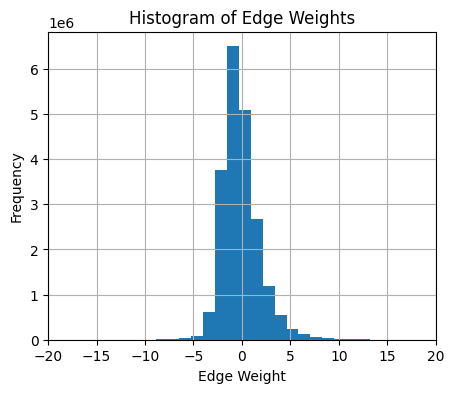

In [ ]:
print("Min value: ", adj.values.flatten().min())
print("Max value: ", adj.values.flatten().max())
# plot a histogram of the edge weights but only between -20 and 20
plt.figure(figsize=(5, 4))
plt.xlim(-20, 20)
plt.grid()
plt.hist(adj.values.flatten(), bins=100)
plt.title('Histogram of Edge Weights')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')


In [ ]:
# Set thresholds for filtering edges
thresholds = [-3,-2,-1,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
# Collect statistics for each threshold
statistics_list = collect_statistics(thresholds, G)

Threshold:  -3
Total number of nodes:  18576
Total number of edges:  20484892
-----------------------------
Total number of target genes:  6185
Total number of target genes in landmark:  939
Total number of target genes in best_inferred:  4411
Total number of target genes in inferred:  835
-----------------------------
Total experiment score:  307495
Total experiment score in landmark:  94640
Total experiment score in best_inferred:  189943
Total experiment score in inferred:  22912
Threshold:  -2
Total number of nodes:  18576
Total number of edges:  18463472
-----------------------------
Total number of target genes:  6185
Total number of target genes in landmark:  939
Total number of target genes in best_inferred:  4411
Total number of target genes in inferred:  835
-----------------------------
Total experiment score:  307495
Total experiment score in landmark:  94640
Total experiment score in best_inferred:  189943
Total experiment score in inferred:  22912
Threshold:  -1
Total num

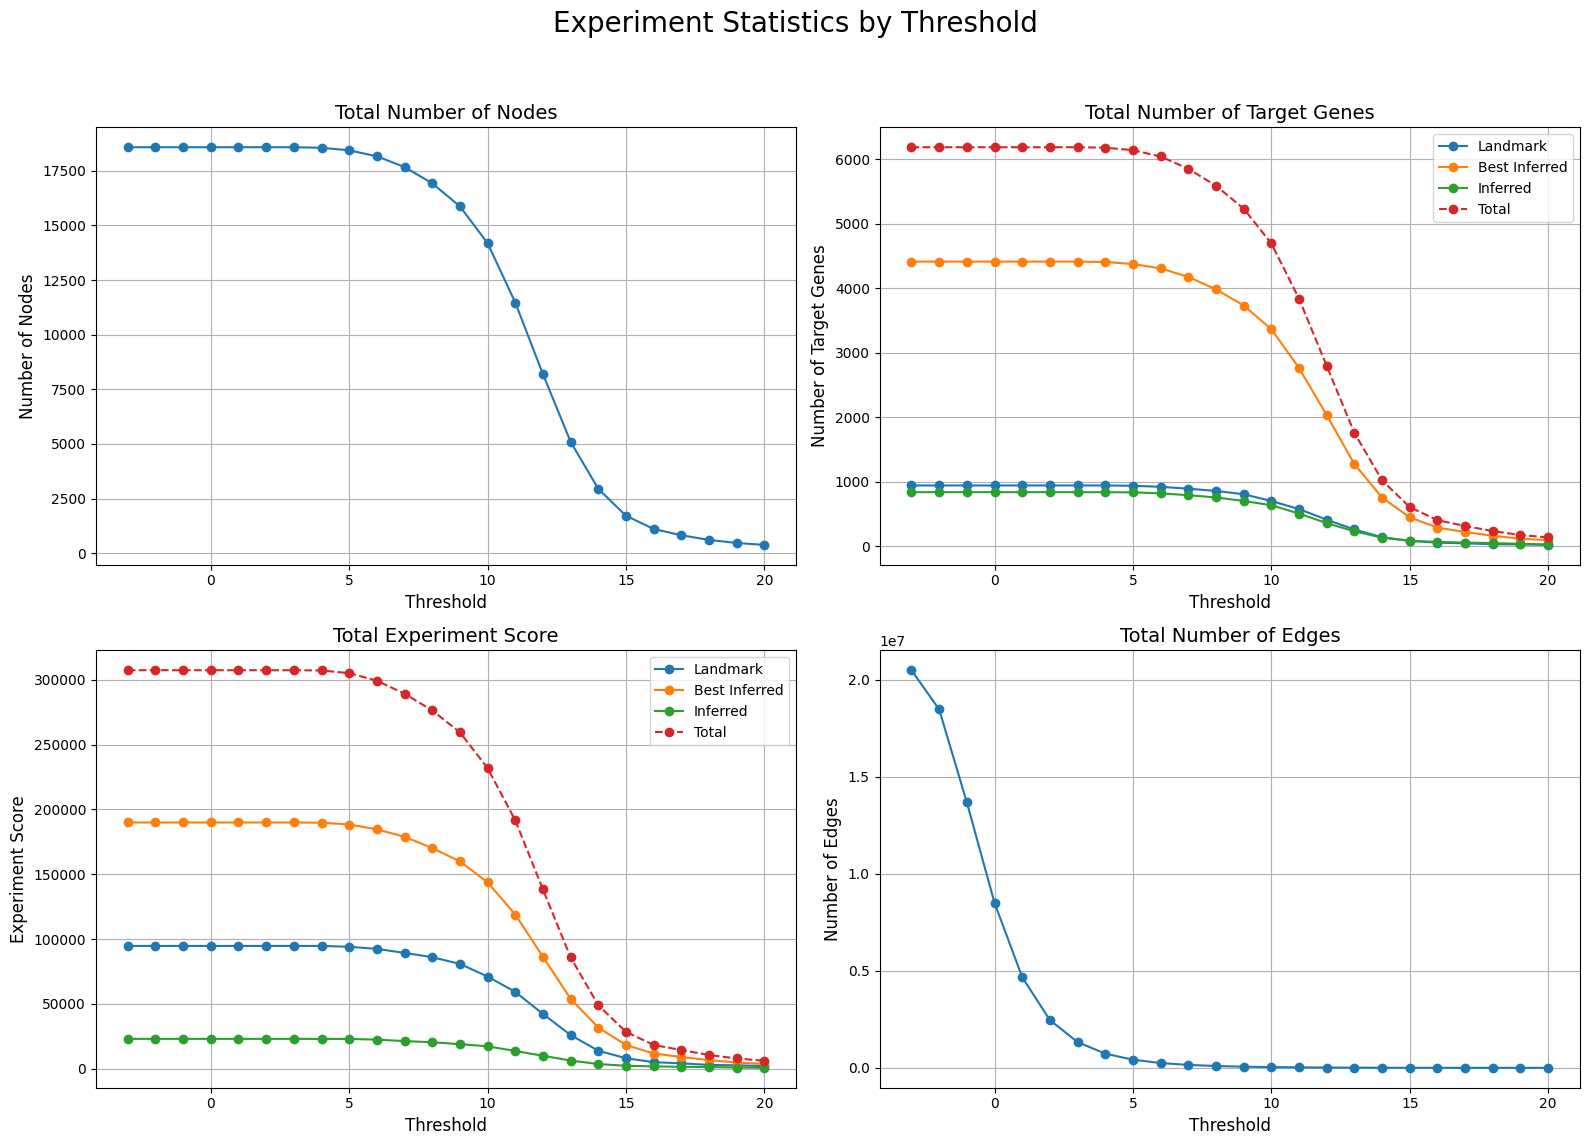

In [ ]:
# Plot the statistics
plot_statistics_list(statistics_list, thresholds)

In [ ]:
# Collect statistics for each threshold
statistics_list_landmark = collect_statistics(thresholds, G_landmark)

Threshold:  -3
Total number of nodes:  962
Total number of edges:  61453
-----------------------------
Total number of target genes:  939
Total number of target genes in landmark:  939
Total number of target genes in best_inferred:  0
Total number of target genes in inferred:  0
-----------------------------
Total experiment score:  94640
Total experiment score in landmark:  94640
Total experiment score in best_inferred:  0
Total experiment score in inferred:  0
Threshold:  -2
Total number of nodes:  962
Total number of edges:  55649
-----------------------------
Total number of target genes:  939
Total number of target genes in landmark:  939
Total number of target genes in best_inferred:  0
Total number of target genes in inferred:  0
-----------------------------
Total experiment score:  94640
Total experiment score in landmark:  94640
Total experiment score in best_inferred:  0
Total experiment score in inferred:  0
Threshold:  -1
Total number of nodes:  962
Total number of edges: 

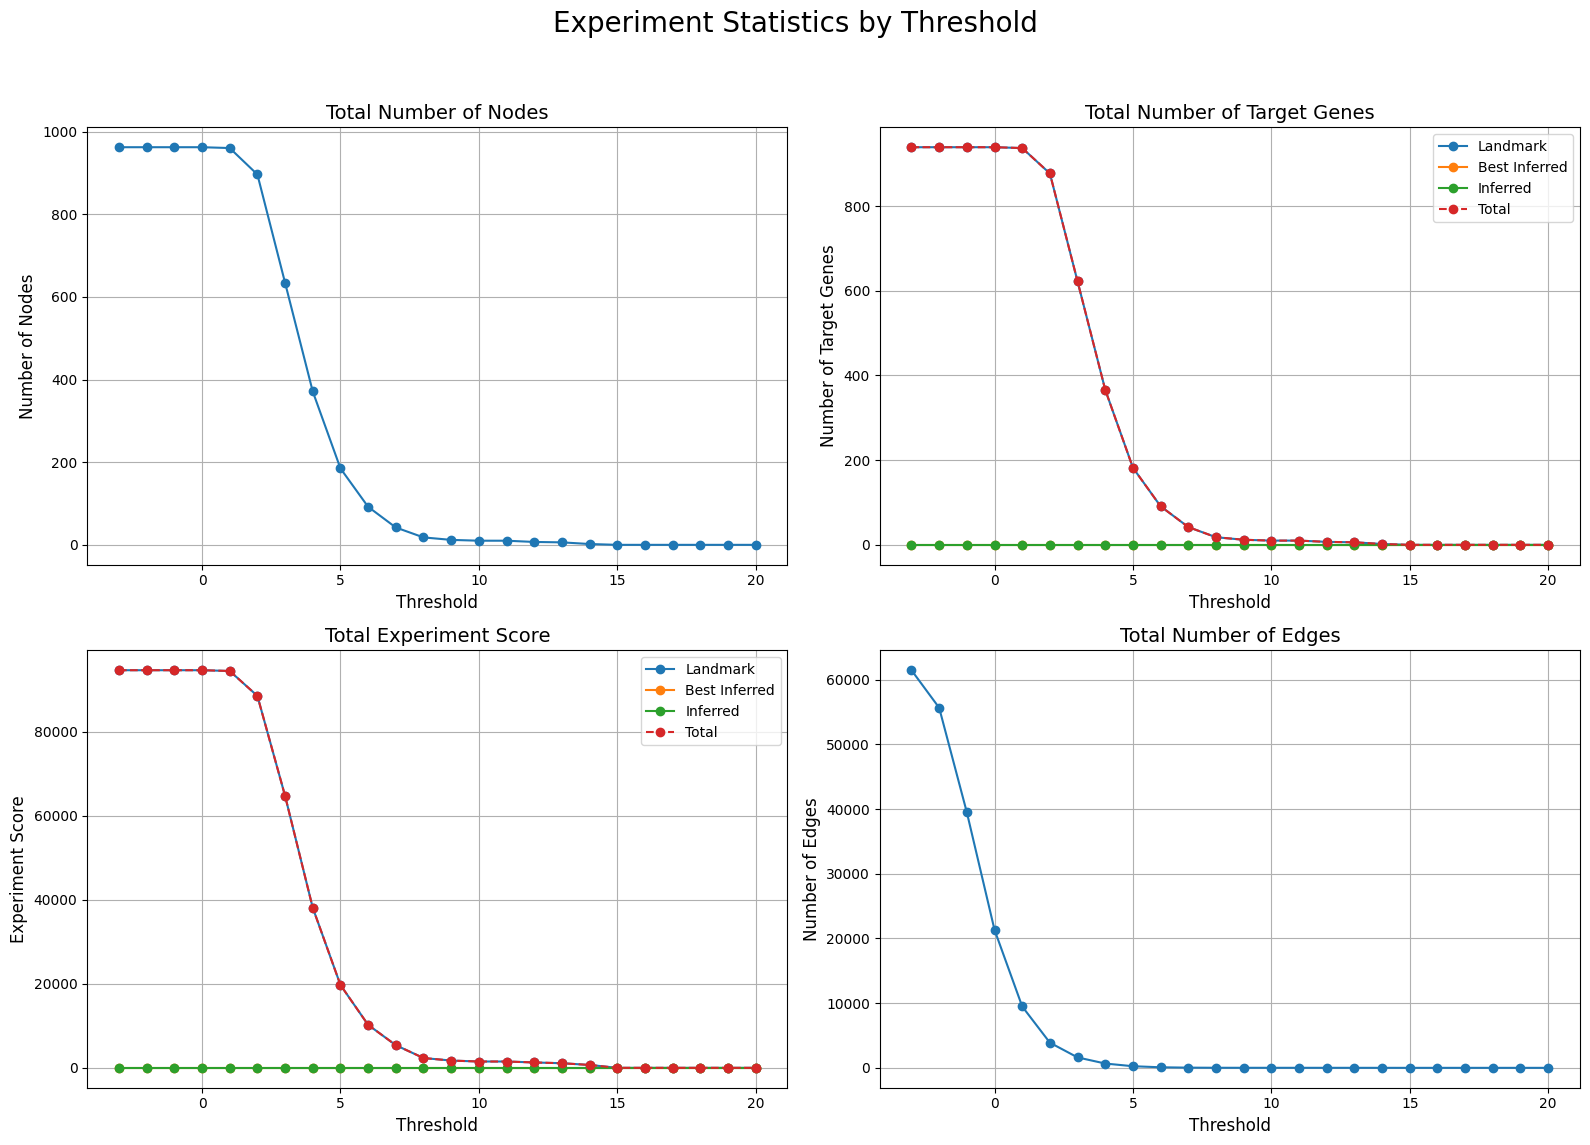

In [ ]:
# Plot the statistics
plot_statistics_list(statistics_list_landmark, thresholds)